# Perceptron实现分类

## 数据集使用Iris

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold #分层交叉验证
import seaborn as sn

In [268]:
path = '/home/ysq/桌面/感知机/iris.data'
names = ['sepal length','sepal width','petal length','petal width','class']
df = pd.read_csv(path,names=names)
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [269]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


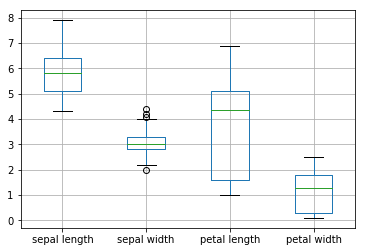

In [270]:
#展示离群点
%matplotlib inline
df.boxplot()
plt.show()

## 为类别进行编码

In [271]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()#编码器
label = df.values[:,-1:]
label = encoder.fit_transform(label)#编码

/home/ysq/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [272]:
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## 取出数据，并对数据进行标准化处理

In [273]:
from sklearn.preprocessing import StandardScaler#标准化
features = df.values[:,:-1]
standard = StandardScaler()#标准化
features = standard.fit_transform(features)
features.shape

/home/ysq/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ysq/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(150, 4)

## 数据可视化

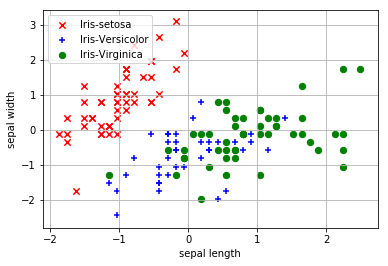

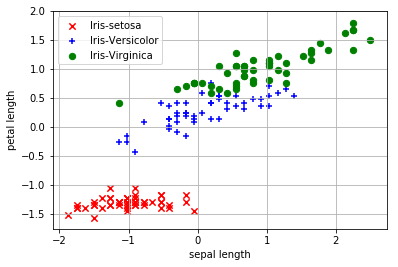

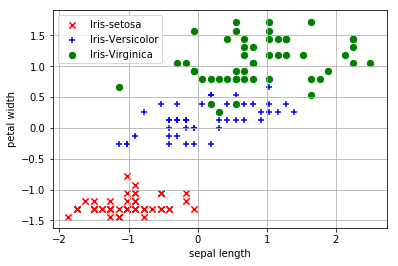

In [274]:
def visualization_data(feature1,feature2):
    #获取第一类花的数据
    x1 = feature1[:50]
    x2 = feature2[:50]
    #第二类花的数据
    y1 = feature1[50:100]
    y2 = feature2[50:100]
    #第三类
    z1 = feature1[100:150]
    z2 = feature2[100:150]
    #画图
    plt.grid()
    plt.scatter(x1,x2,marker = 'x',color = 'red',s = 40,label = 'Iris-setosa')
    plt.scatter(y1,y2,marker = '+',color = 'blue',s = 40,label = 'Iris-Versicolor')
    plt.scatter(z1,z2,marker = 'o',color = 'green',s = 40,label = 'Iris-Virginica')
    leg = plt.legend(loc='upper left', fancybox=True)
    plt.show()

feature1 = features[:,0:1]
feature2 = features[:,1:2]
feature3 = features[:,2:3]
feature4 = features[:,3:4]

plt.xlabel('sepal length')
plt.ylabel('sepal width')
visualization_data(feature1,feature2) 

plt.xlabel('sepal length')
plt.ylabel('petal length')
visualization_data(feature1,feature3)

plt.xlabel('sepal length')
plt.ylabel('petal width')
visualization_data(feature1,feature4)

## 构建感知机算法

In [275]:
class Perceptron:
    """
        感知机算法，对数据进行二分类
    """
    def __init__(self,data,label,test_data,test_label):
        """
            注意，此感知机仅能实现线性可分的二分类问题，Iris数据集有三类，是一个多分类问题，
            需要C(3,2)=3个二分类器来实现，
            此处参数说明如下:
            ---------------------
            data:三类数据中某两类数据的feature数据
            label:传入数据对应的两个标签
            test_data:测试数据
            test_label:测试标签
        """
        self.data = data
        self.label = label
        self.test_data = test_data
        self.test_label = test_label

    def augment_data(self):
        """
            对数据进行增广处理，在第一列增加全1列向量作为偏置
        """
        lenth = self.data.shape[0]#获取列向量应该具有的长度
        one_vector = np.ones(lenth).reshape(-1,1)#产生列向量
        self.data = np.concatenate((one_vector,self.data),axis=1)#按列合并，对数据增广
        lenth2 = self.test_data.shape[0]
        one_vector2 = np.ones(lenth2).reshape(-1,1)#产生列向量
        self.test_data = np.concatenate((one_vector2,self.test_data),axis=1)#按列合并，对数据增广
    
    def train(self):
        """
            初始化权重并训练
        """
        #先对特征进行增广
        self.augment_data()
        #权重初始化
        self.w = np.zeros(self.data.shape[1]).reshape(-1,1)#权重向量初始化为0列向量
        
        #建立一个训练时使用的标签{+1,-1}
        lenth = self.label.shape[0]
        #正例标签+1
        positive = np.array([1 for i in range(lenth//2)]).reshape(-1,1)
        #反例标签-1
        negative = np.array([-1 for i in range(lenth//2)]).reshape(-1,1)
        #训练时使用的标签
        training_label = np.concatenate((positive,negative),axis=0)
        #本轮是否犯错的指标
        flag = True#初始化为犯错
        
        #最大迭代次数
        maxiter = 1000
        current_iter = 0
        while flag and current_iter<maxiter:#当权重在分类时仍犯错,遍历训练集
            count = 0
            for i in range(self.data.shape[0]):#遍历每个训练样本
                sample_vector = self.data[i].reshape(1,-1)#取出样本行向量
                output = np.sign(sample_vector@self.w)#计算感知机输出
                if output != training_label[i]:#若输出与标签不符，修正
                    self.w = self.w + training_label[i]*sample_vector.reshape(-1,1)
                elif output == training_label[i]:#若输出与标签相同
                    count += 1#计算正确划分样本的个数
                if count == self.data.shape[0]:#若全部样本划分正确
                    flag = False#更改标志，退出循环
            
            #修正迭代次数
            current_iter += 1
                #print(f'本轮正确个数为{count}')
        print(f'训练完毕！权重为{self.w}')
    
    def predict(self,sample):
        """
            使用当前权重对样本sample进行预测
        """
        return np.sign(sample@self.w)
    
    def test(self):
        """
            对训练好的模型进行测试
        """
         #建立一个测试时使用的标签{+1,-1}
        lenth = self.test_label.shape[0]
        #正例标签+1
        positive = np.array([1 for i in range(lenth//2)]).reshape(-1,1)
        #反例标签-1
        negative = np.array([-1 for i in range(lenth//2)]).reshape(-1,1)
        #训练时使用的标签
        test_label = np.concatenate((positive,negative),axis=0)
        
        pos_pos = 0#正例到正例
        pos_neg = 0#正例到反例
        neg_pos = 0#反例到正例
        neg_neg = 0#反例到反例
        for i in range(self.test_data.shape[0]):#遍历测试集
            if test_label[i] == 1 and self.predict(self.test_data[i]) == 1:
                pos_pos += 1
            if test_label[i] == 1 and self.predict(self.test_data[i]) == -1:
                pos_neg += 1
            if test_label[i] == -1 and self.predict(self.test_data[i]) == 1:
                neg_pos += 1
            if test_label[i] == -1 and self.predict(self.test_data[i]) == -1:
                neg_neg += 1
        
        confusion_matrix = [[pos_pos,pos_neg],[neg_pos,neg_neg]]
        #绘制混淆矩阵
        plt.figure(figsize=(5,5))
        sn.heatmap(confusion_matrix,annot=True,fmt='d',cmap=plt.cm.Blues)#绘制混淆矩阵
        plt.xlabel('Predict',fontsize = 8)
        plt.ylabel('Ture',fontsize = 8)
        plt.title('Confusion Matrix',fontsize = 10)
        plt.show()
        
    def get_weight(self):
        """
            获取训练好的权重向量
        """
        return self.w

## 训练三个分类器

In [282]:
#对数据和标签处理成二分类模式
data_12 = features[0:100]
data_13 = np.concatenate((features[0:50],features[100:150]),axis=0)#按行合并
data_23 = features[50:150]

label_12 = label[0:100]
label_13 = np.concatenate((label[0:50],label[100:150]),axis=0)
label_23 = label[50:150]

array([[-9.00681170e-01,  1.03205722e+00, -1.34127240e+00,
        -1.31297673e+00],
       [-1.14301691e+00, -1.24957601e-01, -1.34127240e+00,
        -1.31297673e+00],
       [-1.38535265e+00,  3.37848329e-01, -1.39813811e+00,
        -1.31297673e+00],
       [-1.50652052e+00,  1.06445364e-01, -1.28440670e+00,
        -1.31297673e+00],
       [-1.02184904e+00,  1.26346019e+00, -1.34127240e+00,
        -1.31297673e+00],
       [-5.37177559e-01,  1.95766909e+00, -1.17067529e+00,
        -1.05003079e+00],
       [-1.50652052e+00,  8.00654259e-01, -1.34127240e+00,
        -1.18150376e+00],
       [-1.02184904e+00,  8.00654259e-01, -1.28440670e+00,
        -1.31297673e+00],
       [-1.74885626e+00, -3.56360566e-01, -1.34127240e+00,
        -1.31297673e+00],
       [-1.14301691e+00,  1.06445364e-01, -1.28440670e+00,
        -1.44444970e+00],
       [-5.37177559e-01,  1.49486315e+00, -1.28440670e+00,
        -1.31297673e+00],
       [-1.26418478e+00,  8.00654259e-01, -1.22754100e+00,
      

## 训练第一二类的分类器


------------------第 0 轮
训练完毕！权重为[[-1.        ]
 [-0.4321654 ]
 [ 1.05056946]
 [-1.6157442 ]
 [-1.97384752]]


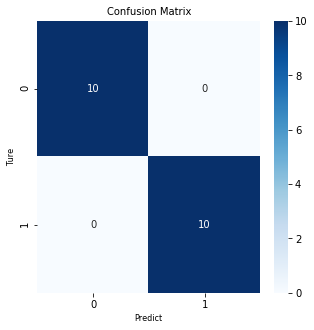


------------------第 1 轮
训练完毕！权重为[[-1.        ]
 [-0.4321654 ]
 [ 1.51337539]
 [-2.63932687]
 [-2.4997394 ]]


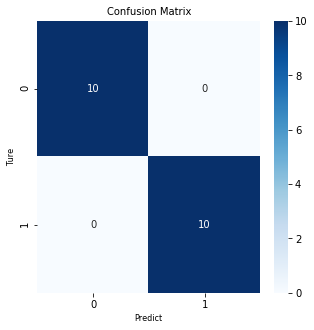


------------------第 2 轮
训练完毕！权重为[[-1.        ]
 [-0.4321654 ]
 [ 1.51337539]
 [-2.63932687]
 [-2.4997394 ]]


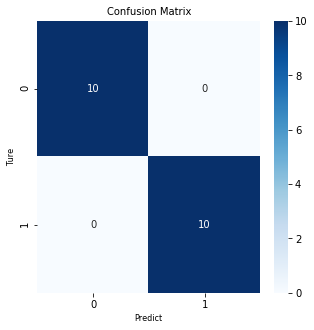


------------------第 3 轮
训练完毕！权重为[[ 0.        ]
 [-0.24233574]
 [ 2.31402965]
 [-2.21776246]
 [-1.97209455]]


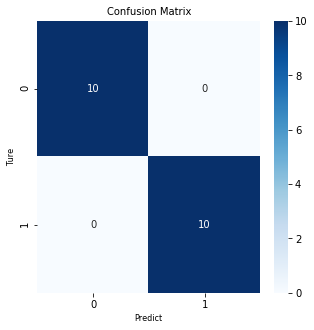


------------------第 4 轮
训练完毕！权重为[[-1.        ]
 [ 0.05250608]
 [ 1.74477836]
 [-1.50201279]
 [-1.57942861]]


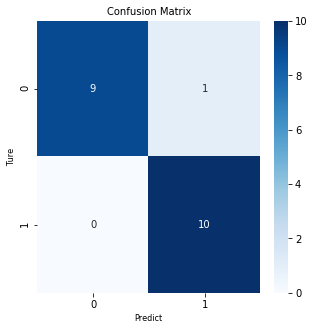

In [277]:
#使用5折分层交叉验证训练12类分类器
count = 0#计数器
weight_12 = []#储存权重的列表
kfold = StratifiedKFold(n_splits=5)#实例化
for train_index,test_index in kfold.split(data_12,label_12):
    print("\n------------------第",count,"轮")
    X_train,X_test=data_12[train_index],data_12[test_index]#划分X空间
    y_train,y_test=label_12[train_index],label_12[test_index]

    module = Perceptron(X_train,y_train,X_test,y_test)#模型实例化
    module.train()
    module.test()
    weight_12.append(module.get_weight())#权重存进列表
    count += 1

## 训练第一三类的分类器


------------------第 0 轮
训练完毕！权重为[[ 1.        ]
 [-0.53717756]
 [ 1.49486315]
 [-1.2844067 ]
 [-1.31297673]]


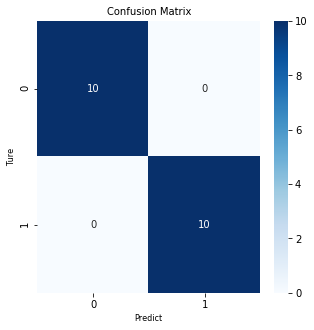


------------------第 1 轮
训练完毕！权重为[[ 1.        ]
 [-0.90068117]
 [ 1.03205722]
 [-1.3412724 ]
 [-1.31297673]]


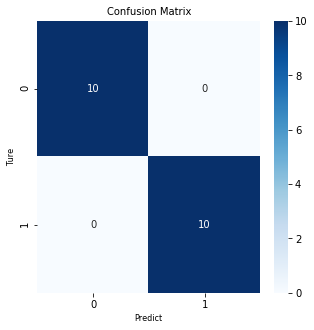


------------------第 2 轮
训练完毕！权重为[[ 1.        ]
 [-0.90068117]
 [ 1.03205722]
 [-1.3412724 ]
 [-1.31297673]]


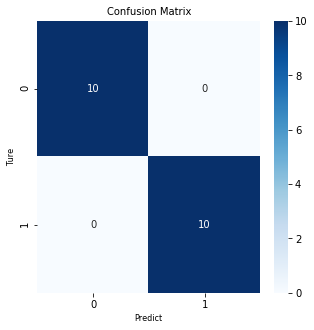


------------------第 3 轮
训练完毕！权重为[[ 1.        ]
 [-0.90068117]
 [ 1.03205722]
 [-1.3412724 ]
 [-1.31297673]]


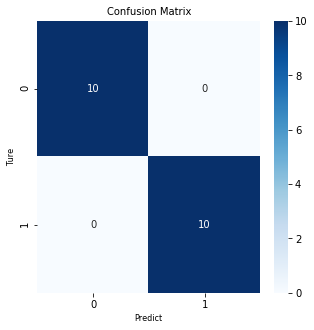


------------------第 4 轮
训练完毕！权重为[[ 1.        ]
 [-0.90068117]
 [ 1.03205722]
 [-1.3412724 ]
 [-1.31297673]]


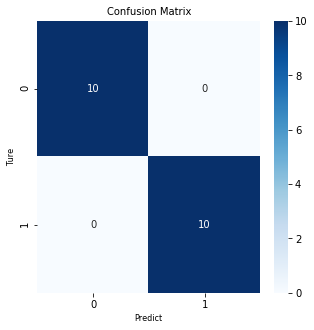

In [278]:
#使用5折分层交叉验证训练12类分类器
count = 0#计数器
weight_13 = []#储存权重的列表
kfold = StratifiedKFold(n_splits=5)#实例化
for train_index,test_index in kfold.split(data_13,label_13):
    print("\n------------------第",count,"轮")
    X_train,X_test=data_13[train_index],data_13[test_index]#划分X空间
    y_train,y_test=label_13[train_index],label_13[test_index]

    module = Perceptron(X_train,y_train,X_test,y_test)#模型实例化
    module.train()
    module.test()
    weight_13.append(module.get_weight())#权重存进列表
    count += 1

## 训练第二三类的分类器
***
- 此处遇到了问题，第二三类是线性不可分的！我们引入了一个最大迭代次数来迫使算法退出



------------------第 0 轮
训练完毕！权重为[[ 37.        ]
 [  0.60180042]
 [  6.48391108]
 [-33.13602482]
 [-23.73174757]]


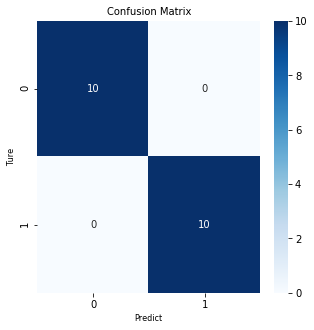


------------------第 1 轮
训练完毕！权重为[[ 26.        ]
 [  1.17936727]
 [  4.85020615]
 [-18.15456555]
 [-20.33273306]]


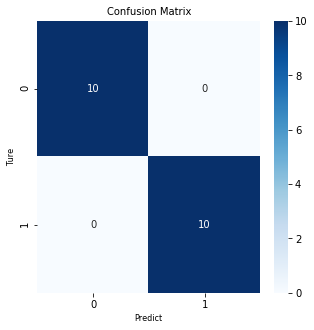


------------------第 2 轮
训练完毕！权重为[[ 11.        ]
 [  2.45162991]
 [  0.93949604]
 [-15.4363849 ]
 [ -6.02847392]]


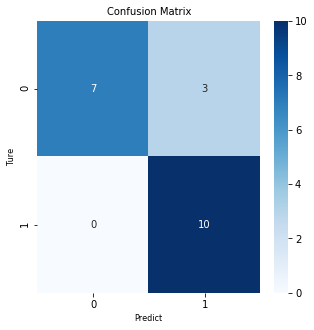


------------------第 3 轮
训练完毕！权重为[[ 12.        ]
 [  2.88379532]
 [  1.97155326]
 [-12.22840099]
 [ -6.15819392]]


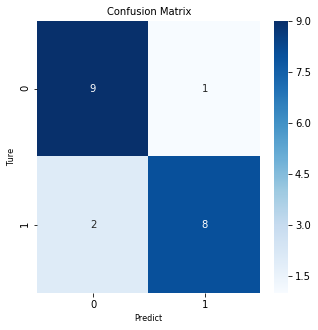


------------------第 4 轮
训练完毕！权重为[[ 27.        ]
 [  3.42905073]
 [  4.72524855]
 [-26.37658814]
 [-18.88477741]]


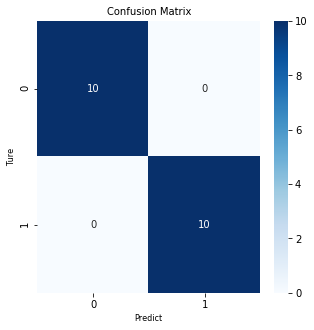

In [279]:
#使用5折分层交叉验证训练12类分类器
count = 0#计数器
weight_23 = []#储存权重的列表
kfold = StratifiedKFold(n_splits=5)#实例化
for train_index,test_index in kfold.split(data_23,label_23):
    print("\n------------------第",count,"轮")
    X_train,X_test=data_23[train_index],data_23[test_index]#划分X空间
    y_train,y_test=label_23[train_index],label_23[test_index]

    module = Perceptron(X_train,y_train,X_test,y_test)#模型实例化
    module.train()
    module.test()
    weight_23.append(module.get_weight())#权重存进列表
    count += 1

# 将三个分类器集成
***
- 观察上面的混淆矩阵，选取三个权重列表中的第一个权重用于实现三分类

In [280]:
w_12 = weight_12[0]
w_13 = weight_13[0]
w_23 = weight_23[0]

## 使用上面三个分类器对全部样本进行分类

In [300]:
#对数据进行增广处理
data = features
lenth = features.shape[0]
one_vector = np.ones(lenth).reshape(-1,1)
data = np.concatenate((one_vector,data),axis=1)#增广

In [291]:
def prediction(sample,w12,w13,w23):
    """
        对某一个数据进行分类，由三个分类器投票决定i
        ------------------------------
        sample是待预测样本
        w是三个权重向量
    """
    #投票信息
    class1 = 0#第一类票数
    class2 = 0#第二类票数
    class3 = 0
    #分类器进行决策
    if np.sign(sample@w12) == 1:
        class1 += 1
    else:
        class2 += 1
        
    if np.sign(sample@w13) == 1:
        class1 += 1
    else:
        class3 += 1
        
    if np.sign(sample@w23) == 1:
        class2 += 1
    else:
        class3 += 1
    
    #投票决定最终分类
    vote_box = np.array([class1,class2,class3])#投票箱
    index = np.argmax(vote_box)#返回最大下标，此处下标恰好是label
    return index#返回类别

In [294]:
#进行分类
hypothesis = []#预测的类别号，即分类结果
for i in range(data.shape[0]):#遍历所有样本
    hypothesis.append(prediction(data[i],w_12,w_13,w_23))

## 绘制混淆矩阵

In [305]:
from sklearn.metrics import confusion_matrix#混淆矩阵
y_true = label #真实
y_pred = hypothesis#预测
names = ['Iris-setosa','Iris-Versicolor','Iris-Virginica']
matrix = confusion_matrix(y_true,y_pred)

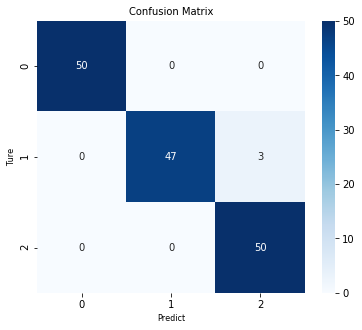

In [314]:
#绘制混淆矩阵
plt.figure(figsize=(6,5))
sn.heatmap(matrix,annot=True,fmt='d',cmap=plt.cm.Blues)#绘制混淆矩阵
plt.xlabel('Predict',fontsize = 8)
plt.ylabel('Ture',fontsize = 8)
plt.title('Confusion Matrix',fontsize = 10)
plt.show()

## 计算OA，AA

In [318]:
Overall = (50+47+50)/150
AA = (50/50+47/50+50/50)/3
print(f'Overall Accuracy:{Overall}  Average Accuracy:{AA}')

Overall Accuracy:0.98  Average Accuracy:0.98
